<a href="https://colab.research.google.com/github/imanhamid/selectionscan_NN/blob/master/objectlocalization_one_strong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install & import icevision (ignore commented line) & mount at your google drive (change directories if necessary)

In [ ]:
#pip install git+git://github.com/airctic/icevision.git#egg=icevision[all] --upgrade
!pip install icevision[all]

In [2]:
from icevision.all import *

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [4]:
import pandas as pd
import numpy as np

You should have access to the segmentation folder, but let me know if you don't.

In [5]:
path = Path(base_dir + 'data/segmentation/one-strong/')

Specify directories. The "images" folder has the actual ancestry-painted images. The "labels" folder has the segmentation masks, which we don't really need for object localization (though we can, if we want to use  [MaskRCNN](https://airctic.com/mask_rcnn_pennfudan/) which is segmentation + object localization).




In [6]:
path_lbl = path/'labels'
path_img = path/'images'
fnames = get_image_files(path_img)

Calculate bounding box vertices as 5 pixels +/- the variant position. Variant location (physical position) is taken from the image file name, and converted to pixel coordinates.

Bbox is formated as \[xmin, ymin, xmax, ymax], with indices started at 0 from the bottom left corner.

In [8]:
pos = [int(re.search("pos-(.*)_seed", str(i)).group(1)) for i in fnames]
bbox_xmin = [math.ceil((i / 25e6) * 200) - 5 for i in pos]
labl_bbox = [[i, 0, i + 11, 200] for i in bbox_xmin]
image_id = [re.search("/images/(.*.png)", str(i)).group(1) for i in fnames]

Combine image filename, image width, image height, bbox, and source \[which is the "images" directory] in dataframe (for input to icevision parser).

In [9]:
df = pd.DataFrame(list(zip(image_id, [200] * len(image_id), [200] * len(image_id), labl_bbox, [str(path_img) for i in image_id])), 
               columns =['image_id', 'width', 'height', 'bbox', 'source']) 

Creat custom parser. I followed [this tutorial](https://airctic.com/custom_parser/) with some modifications.

In [10]:
class VariantParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    pass

In [11]:
VariantParser.generate_template()

def __iter__(self) -> Any:
def imageid(self, o) -> Hashable:
def image_width_height(self, o) -> Tuple[int, int]:
    return get_image_size(self.filepath(o))
def filepath(self, o) -> Union[str, Path]:
def bboxes(self, o) -> List[BBox]:
def labels(self, o) -> List[int]:


In [12]:
class VariantParser(parsers.FasterRCNN, parsers.FilepathMixin, parsers.SizeMixin):
    def __init__(self, df, source):
        self.df = df
        self.source = source

    def __iter__(self):
        yield from self.df.itertuples()

    def __len__(self):
        return len(self.df)

    def imageid(self, o) -> Hashable:
        return o.image_id

    def filepath(self, o) -> Union[str, Path]:
        return self.source / f"{o.image_id}"

    def image_width_height(self, o) -> Tuple[int, int]:
        return get_image_size(self.filepath(o))

    def labels(self, o) -> List[int]:
        return [1]

    def bboxes(self, o) -> List[BBox]:
        return [BBox.from_xyxy(*np.fromiter(o.bbox, dtype="int"))]

Create class map. This is necessary, even though there is only one class.

In [13]:
class_map = ClassMap(['selected_variant'])

Split data to training and validation records. I set a random seed so we can be comparing with the same train/valid sets. 800 images in training set, 200 in validation set.

This may take a couple minutes to run.

In [15]:
parser = VariantParser(df, path_img)
train_rs, valid_rs = parser.parse(data_splitter=RandomSplitter([0.8, 0.2], seed=42))

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:126
AUTOFIX-START - ️🔨  Autofixing record with imageid: 678  ️🔨 | icevision.core.record:_pre_replay:92
AUTOFIX-SUCCESS - Clipping bbox xmax from 204 to image width 200 (Before: <BBox (xmin:193, ymin:0, xmax:204, ymax:200)>) | icevision.core.bbox:autofix:79
AUTOFIX-START - ️🔨  Autofixing record with imageid: 687  ️🔨 | icevision.core.record:_pre_replay:92
AUTOFIX-SUCCESS - Clipping bbox xmax from 206 to image width 200 (Before: <BBox (xmin:195, ymin:0, xmax:206, ymax:200)>) | icevision.core.bbox:autofix:79
AUTOFIX-START - ️🔨  Autofixing record with imageid: 692  ️🔨 | icevision.core.record:_pre_replay:92
AUTOFIX-SUCCESS - Clipping bbox xmin from -3 to 0 (Before: <BBox (xmin:-3, ymin:0, xmax:8, ymax:200)>) | icevision.core.bbox:autofix:65
AUTOFIX-START - ️🔨  Autofixing record with imageid: 662  ️🔨 | icevision.core.record:_pre_replay:92
AUTOFIX-SUCCESS - Clipping bbox xmax from 201 to image width 200 (Before: <BBox (xmin:190, ym

Make sure everything looks correct.

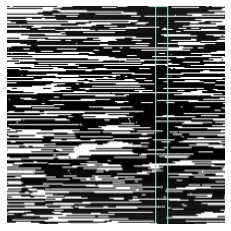

In [16]:
show_record(train_rs[30], display_label=False)

In [17]:
len(train_rs), len(valid_rs)

(800, 200)

In [18]:
train_ds = Dataset(train_rs)
valid_ds = Dataset(valid_rs)

Create dataloaders and define the model we're using ([FasterRCNN](https://airctic.com/model_faster_rcnn/), resnet18 architecture)

In [19]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

In [20]:
backbone = faster_rcnn.backbones.resnet_fpn.resnet18(pretrained=True)
model = faster_rcnn.model(backbone=backbone, num_classes=len(class_map))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Define custom metrics & wrap in Metric class

* Center proportion (center_metric) = proportion of predicted bboxes that contain the selected variant. (should be close to 1)
* Average width (width_metric) = average width of bboxes (should be ~11 pixels wide)
* Number of boxes (num_bboxes) = average number of predicted bboxes per image (should be close to 1)



In [21]:
def center_metric(sample, pred):
  bbox_pred = pred['bboxes']
  if len(bbox_pred)>0:
    bbox_xaxis_pred = [i.xyxy[0:3:2] for i in bbox_pred]
    bbox_sample = sample['bboxes'][0]
    bbox_xaxis_sample = bbox_sample.xyxy[0:3:2]
    sample_midpoint = math.ceil((bbox_xaxis_sample[0] + bbox_xaxis_sample[1])/2)
    center_in_bbox = [i[1] >= sample_midpoint >= i[0] for i in bbox_xaxis_pred]
    center_accuracy_mean = np.mean(center_in_bbox)
  else:
    center_accuracy_mean = 0
  return center_accuracy_mean

def width_metric(pred):
  bbox_pred = pred['bboxes']
  if len(bbox_pred)>0:
    bbox_xaxis_pred = [i.xyxy[0:3:2] for i in bbox_pred]
    pred_width = [i[1] - i[0] for i in bbox_xaxis_pred]
    pred_width_mean = np.mean(pred_width)
  else:
    pred_width_mean = None
  return pred_width_mean
  

def num_bboxes(pred):
  num_boxes = len(pred['bboxes'])
  return num_boxes
  

For all metrics, the idea here is to calculate the metric for all validation records (200 images) and collect them by batches (accumulate), and average across all records at the end of each epoch (finalize). Then, the accumulated metrics need to be cleared at the end of each epoch so that they can be calculated anew the next cycle.

For average widths: some records will have no predicted bboxes, so the average is not calculated for those values. That is, we calculate the average width only for those bboxes that are predicted. So the denominator may be more or less than the actual number of valiation records. This value will likely be None in the first epoch because no bboxes will be predicted.

In [22]:
class Center_Proportion(Metric):
    def __init__(self):
        self._props = []

    def _reset(self):
        self._props.clear()

    def accumulate(self, records, preds):
        center_results = [center_metric(sample, pred) for sample, pred in zip(records,preds)]
        self._props.extend(center_results)

    def finalize(self) -> Dict[str, float]:
        final_prop = np.mean(self._props)
        self._reset()
        return {'Center_in_Bbox': final_prop}

class Avg_Width(Metric):
    def __init__(self):
        self._widths = []

    def _reset(self):
        self._widths.clear()

    def accumulate(self, records, preds):
        width_results = [width_metric(pred) for pred in preds]
        for i in width_results:
          if i:
            self._widths.append(i)
          else:
            pass

    def finalize(self) -> Dict[str, float]:
        if self._widths:
          final_avg = np.mean(self._widths)
        else:
          final_avg = None
        self._reset()
        return {'Width_Bbox': final_avg}

class Num_Bboxes(Metric):
    def __init__(self):
        self._num = []

    def _reset(self):
        self._num.clear()

    def accumulate(self, records, preds):
        num_boxes_results = [num_bboxes(pred) for pred in preds]
        self._num.extend(num_boxes_results)

    def finalize(self) -> Dict[str, float]:
        final_num = np.mean(self._num)
        self._reset()
        return {'Num_Bbox': final_num}

Define the fastai learner, specifying metrics. I included COCOMetric(), which is commonly used for bboxes. It is essentialy IoU.

We could also use PyTorch Lightening instead of FastAI, but I'm sticking with FastAI since we're familiar with it.

In [24]:
metrics = [COCOMetric(), Num_Bboxes(), Center_Proportion(), Avg_Width()]
learn = faster_rcnn.fastai.learner(
    dls=[train_dl, valid_dl], model=model, metrics=metrics
)

Keep in mind that metric values don't seem to match the true values when we export the model and infer/predict on our validation set. I'm still not clear why the numbers don't match.

This will take ~10-15 min to train (may also depend on your network connection).

In [91]:
learn.fine_tune(30, base_lr=3e-3, freeze_epochs=1, wd=1e-2)

epoch,train_loss,valid_loss,COCOMetric,Num_Bboxes,Center_Proportion,Avg_Width,time
0,2.077626,2.045801,0.000000,2.160000,0.353995,58.30571,00:24


epoch,train_loss,valid_loss,COCOMetric,Num_Bboxes,Center_Proportion,Avg_Width,time
0,0.685105,0.423369,0.046022,29.860000,0.067468,11.708782,00:36
1,0.422054,0.277054,0.058491,21.405000,0.117466,11.567344,00:35
2,0.301233,0.202329,0.124113,14.440000,0.264306,14.100574,00:36
3,0.235656,0.183725,0.161214,11.420000,0.313925,14.627693,00:36
4,0.191643,0.165079,0.212376,10.605000,0.336840,14.26706,00:35
5,0.173583,0.151716,0.243390,6.035000,0.410157,11.517007,00:35
6,0.166666,0.263770,0.218861,6.155000,0.465831,11.675685,00:35
7,0.160190,0.156304,0.303041,5.380000,0.550068,13.912756,00:36
8,0.152088,0.141321,0.307250,4.680000,0.518923,11.449315,00:35
9,0.142203,0.157283,0.284003,3.680000,0.604857,10.520421,00:35


Run inference on the validation set. Confirm accuracy with each of the relevant metrics.

In [92]:
infer_dl = faster_rcnn.infer_dl(valid_ds, batch_size=16)
samples, preds = faster_rcnn.predict_dl(model, infer_dl)

  0%|          | 0/13 [00:00<?, ?it/s]

In [93]:
center_results = [center_metric(sample, pred) for sample, pred in zip(samples,preds)]
num_boxes_results = [num_bboxes(pred) for pred in preds]
width_results = [width_metric(pred) for pred in preds]
final_widths = []
for i in width_results:
    if i:
      final_widths.append(i)
    else:
      pass
np.mean(center_results), np.mean(num_boxes_results), np.mean(final_widths)

(0.895, 1.02, 10.832966)

Pretty good! We're averaging 1 predicted bounding box per image, the variant is detected w/in the bounding boxes for ~90% of validation images, and the average bounding box has a width of ~11 pixels!

I trained this exact same model 3 times to confirm, and the avg center proportion metric is 90.6%, num boxes ~1.02, and avg box width ~10.83 pixels. These results were consistent and had low variance across the three replicates, so I'm fairly confident you should get approximately the same accuracy in training.

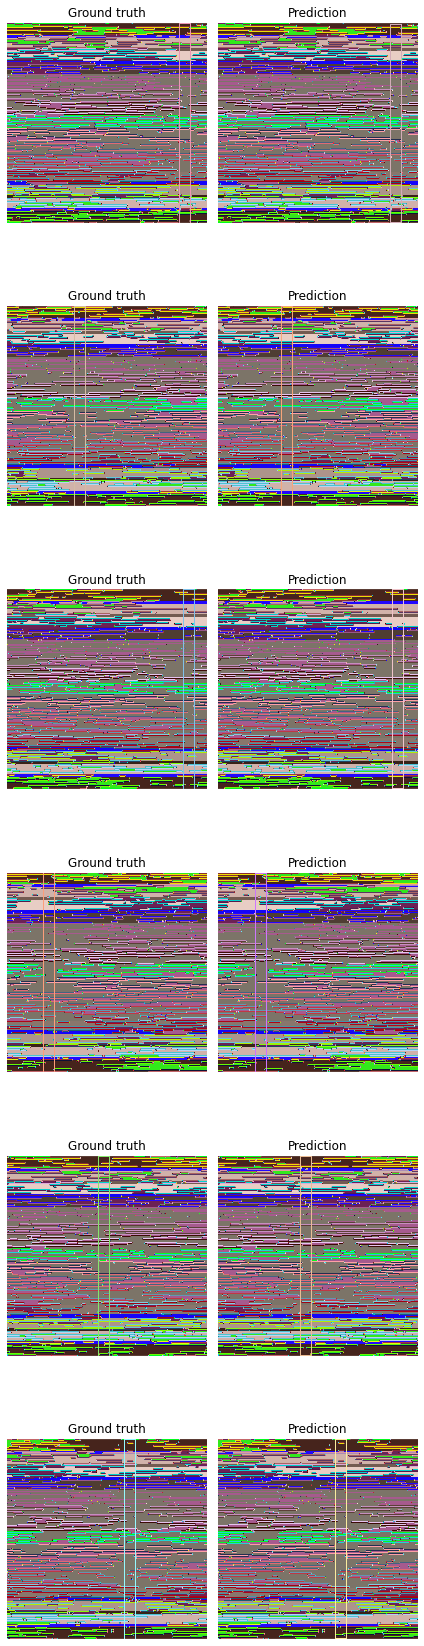

In [94]:
show_preds(samples[:6], preds[:6], class_map, display_label=False, display_mask=False)